# Analysis of ensembles

In [1]:
import pandas
import matplotlib.pyplot as plt
import geopandas
from gerrychain import Graph, Partition, updaters
from numpy import sqrt, arange

In [2]:
gdf = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp")
# current_plan = gdf.groupby("ward").sum()
# current_partition = Partition(Graph.from_geodataframe(gdf), gdf["ward"], {"cut_edges": updaters.cut_edges})

## Finding interesting plans

In [7]:
def population_deviation(data):
    first_plan = data[data["step"] == 0]
    ideal = first_plan["TOTPOP"].sum() / len(first_plan)
    deviation = abs(data["TOTPOP"] - ideal) / ideal
    return deviation

In [8]:
def majority_black_wards(data):
    number_majority_black = (data["NH_BLACK"] / data["TOTPOP"] > 0.5)
    return number_majority_black

In [9]:
def segregated(data):
    groups = ["NH_BLACK", "NH_WHITE", "NH_ASIAN", "HISP"]
    return data[groups].apply(lambda x: (x / data["TOTPOP"]) > 0.5).any(axis=1)

In [10]:
def compactness(plans):
    return plans["cut_edges"].min()

In [11]:
def all_households(df):
    return df[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum(axis=1)

In [12]:
def below_20k(df):
    return df[[ 'LESS_10K', '10K_15K', '15K_20K']].sum(axis=1)

In [13]:
def above_150k(df):
    return df[['150K_200K', '200K_MORE']].sum(axis=1)

In [14]:
def has_concentrated_wealth(df):
    return ((above_150k(df) / all_households(df)) > 0.25)

def has_concentrated_poverty(df):
    return ((below_20k(df) / all_households(df)) > 0.25)

def has_concentrated_wealth_or_poverty(df):
    return has_concentrated_wealth(df) | has_concentrated_poverty(df)

In [ ]:
def groups_over_threshold(data, threshold):
    groups = ["NH_BLACK", "NH_WHITE", "NH_ASIAN", "HISP"]
    return data[groups].apply(lambda x: (x / data["TOTPOP"]) > threshold).sum(axis=1)

In [16]:
def multiracial(data, threshold=0.25):
    over_threshold = groups_over_threshold(data, threshold)
    return (over_threshold >= 3) | (over_threshold == 0)

In [17]:
def hypersegregated(data, threshold=0.25):
    return groups_over_threshold(data, threshold) == 1

In [ ]:
df = pandas.read_csv("../ensembles/prec50/results.csv")

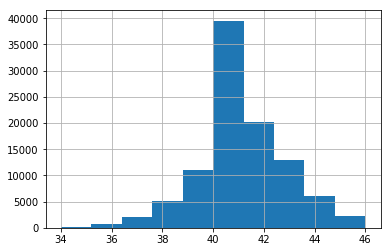

In [14]:
segregated(df).groupby(df["step"]).sum().hist()

## Analyzing outcomes

### Loading the projected outcomes

In [3]:
df50x1 = pandas.read_csv("../projection/projection_50x1.csv")
df10x5 = pandas.read_csv("../projection/projection_10x5.csv")
df10x3 = pandas.read_csv("../projection/projection_10x3.csv")
df10x3_CA = pandas.read_csv("../projection/projection_10x3_CA.csv")
df10x5_CA = pandas.read_csv("../projection/projection_10x5_CA.csv")

### Projected number of city council seats

In [16]:
groups = ['Asian', 'Black', 'Hispanic', 'White']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D126601D0>,
      dtype=object)

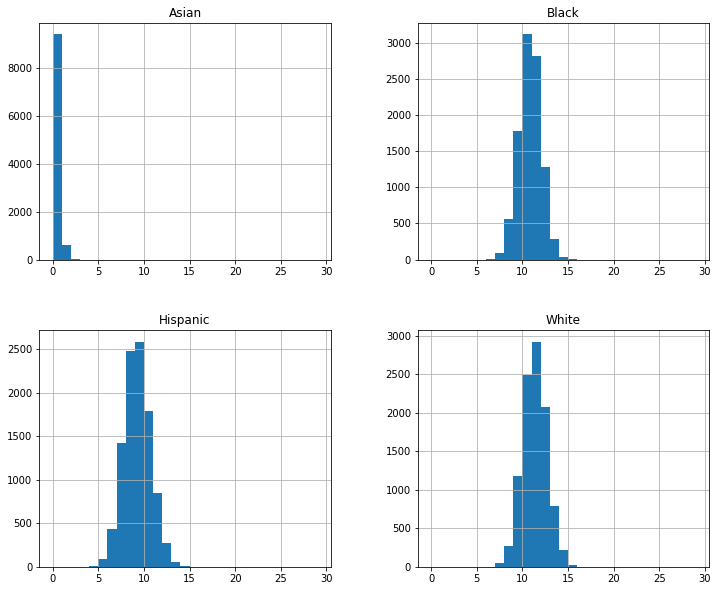

In [17]:
df10x3[groups].hist(figsize=(12,10), bins=list(range(30)))


### Average outcomes

In [18]:
means = pandas.DataFrame({"50x1": df50x1[groups].mean(), "10x5": df10x5[groups].mean(), "10x3": df10x3[groups].mean(), "10x5_CA": df10x5_CA[groups].mean(), "10x3_CA": df10x3_CA[groups].mean()})

In [19]:
means

,50x1,10x5,10x3,10x5_CA,10x3_CA
Asian,0.4472,0.3421,0.0625,0.2251,0.0318
Black,15.6336,16.4632,10.3181,16.8474,10.7753
Hispanic,14.1536,15.6148,8.7613,15.6802,8.8673
White,19.7656,17.5799,10.8581,17.2473,10.3256


In [20]:
means.to_csv("../projection/means.csv")

### City-wide

In [15]:
first_plan = df[df["step"] == 0]

In [18]:
citywide_below20k = below_20k(first_plan).sum() / all_households(first_plan).sum()
citywide_below20k

0.21333095756908763

In [140]:
# citywide_over200k
above_200k(first_plan).sum() / all_households(first_plan).sum()

### Comparing to current plan

In [23]:
# Number of wards with concentrated wealth or poverty, over the ensemble
def hist_with_line_for_current(function, df=df, current_plan=current_plan, bins=range(18,31), **kwargs):
    fig, ax = plt.subplots()
    function(df).groupby(df["step"]).sum().hist(bins=bins, ax=ax, **kwargs)
#     ax.axvline(function(current_plan).sum(), color="r")
    return fig, ax

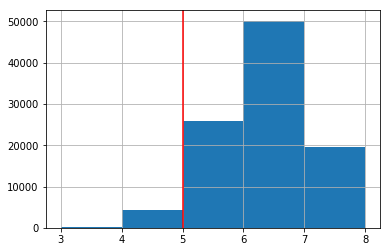

In [58]:
hist_with_line_for_current(has_concentrated_wealth, bins=range(3,9))
plt.show()

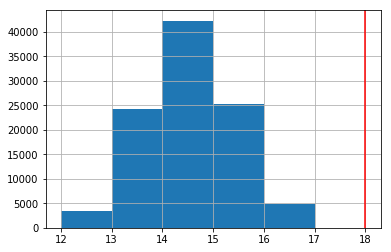

In [61]:
hist_with_line_for_current(majority_black_wards, bins=range(12,18))
plt.show()

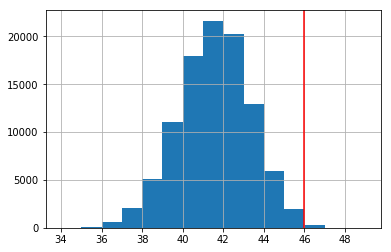

In [59]:
hist_with_line_for_current(segregated, bins=range(34,50))
plt.show()

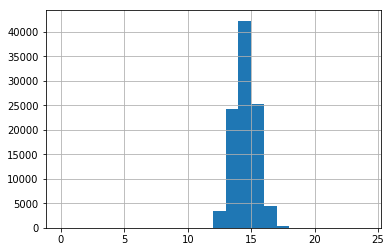

In [55]:
majority_black_wards(df).hist(bins=list(range(25)))
plt.show()

### Segregation and hypersegregation

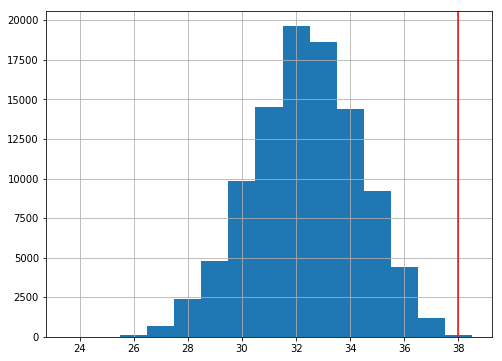

In [25]:
fig, ax = hist_with_line_for_current(hypersegregated, df=df, bins=range(24, 40), figsize=(8,6))
ax.set_xticks(list(x + 0.5 for x in range(24, 40, 2)))
ax.set_xticklabels(list(str(x) for x in range(24, 40, 2)))
ax.axvline(38.5, color="r")
plt.savefig("../figures/prec50_hypersegregated.png")
plt.show()

In [27]:
(hypersegregated(df).groupby(df["step"]).sum() == 38).sum() / df["step"].nunique()

0.00104

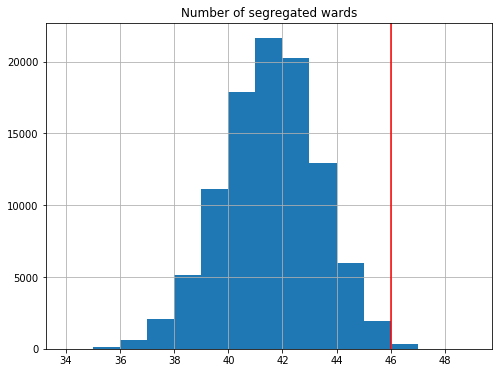

In [78]:
fig, ax = hist_with_line_for_current(segregated, df=df, bins=range(34, 50), figsize=(8,6))
ax.set_xticks(list(range(34, 50, 2)))
ax.set_title("Number of segregated wards")
fig.savefig("../figures/prec50_segregated.png")
plt.show()

## Finding interesting plans

1. Least-segregated
2. Current plan
3. Most majority-black
4. Fewest concentrated poverty

#### 50x1

In [97]:
segregated(df).groupby(df["step"]).sum().min()

34.0

In [96]:
majority_black_wards(df).groupby(df["step"]).sum().max()

17.0

In [95]:
has_concentrated_poverty(df).groupby(df["step"]).sum().min()

13.0

#### 10xM

In [45]:
prec10 = pandas.read_csv("../ensembles/prec10/results.csv")

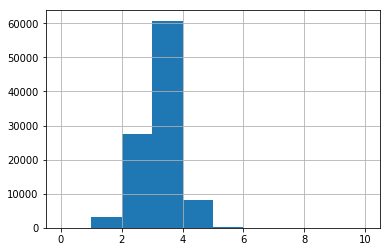

In [86]:
hypersegregated(prec10, threshold=1/6).groupby(prec10["step"]).sum().hist(bins=range(0, 11))

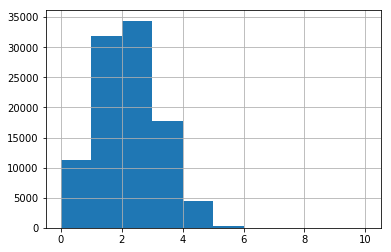

In [85]:
multiracial(prec10, threshold=1/6).groupby(prec10["step"]).sum().hist(bins=range(0,11))

In [89]:
multiracial(prec10, threshold=1/6).groupby(prec10["step"]).sum().idxmax()

55213

In [94]:
has_concentrated_wealth_or_poverty(prec10).groupby(prec10["step"]).sum().idxmin()

205

In [102]:
population_deviation(prec10).groupby(prec10["step"]).max().min()

0.017025676427120568

In [126]:
segregated(prec10).groupby(prec10["step"]).sum().min()

3.0

In [ ]:
segregated(prec10)

#### 10xM CA

In [127]:
ca10 = pandas.read_csv("../ensembles/ca10/results.csv")

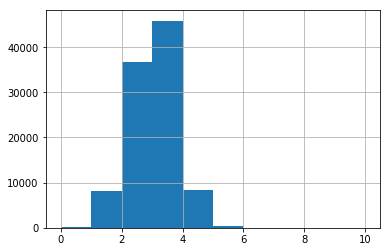

In [128]:
hypersegregated(ca10, threshold=1/6).groupby(ca10["step"]).sum().hist(bins=range(0, 11))

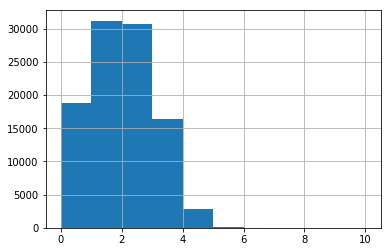

In [133]:
multiracial(ca10, threshold=1/6).groupby(ca10["step"]).sum().hist(bins=range(0,11))

In [134]:
multiracial(ca10, threshold=1/6).groupby(ca10["step"]).sum().idxmax()

25218

In [137]:
has_concentrated_wealth_or_poverty(ca10).groupby(ca10["step"]).sum().idxmin()

5848

In [141]:
population_deviation(ca10).groupby(ca10["step"]).max().min()

0.016237681479992973

In [153]:
segregated(ca10).groupby(ca10["step"]).sum().idxmin()

1042

In [144]:
hypersegregated(ca10, 1/6).groupby(ca10["step"]).sum().idxmin()

937

In [157]:
hypersegregated(ca10, 1/4).groupby(ca10["step"]).sum().min()

3.0

## Income dissimilarity

In [19]:
percent_below_20k = below_20k(df) / all_households(df)

In [21]:
L2_distance_from_citywide = (
    percent_below_20k - citywide_below20k
).apply(lambda x: x**2).groupby(df["step"]).sum().apply(lambda x: sqrt(x))

In [42]:
current_plan_percent_below_20k = (below_20k(current_plan) / all_households(current_plan))
current_plan_L2_from_citywide = sqrt((current_plan_percent_below_20k - citywide_below20k).apply(lambda x: x**2).sum())

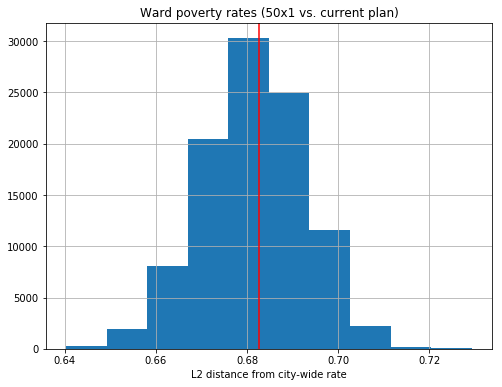

In [61]:
fig, ax = plt.subplots()
L2_distance_from_citywide.hist(ax=ax, figsize=(8,6))
ax.axvline(current_plan_L2_from_citywide, color="r")
ax.set_title("Ward poverty rates (50x1 vs. current plan)")
ax.set_xlabel("L2 distance from city-wide rate")
plt.savefig("./L2_distance_under20k.png")

In [48]:
percent_below_20k_prec10 = below_20k(prec10) / all_households(prec10)

In [49]:
L2_distance_from_citywide_prec10 = (
    percent_below_20k_prec10 - citywide_below20k
).apply(lambda x: x**2).groupby(prec10["step"]).sum().apply(lambda x: sqrt(x))

In [62]:
def index_of_dissimilarity(a, b):
    A = a.sum()
    B = b.sum()
    return 0.5 * (a/A - b/B).apply(abs).sum()

In [64]:
def iod_for_plan(plan):
    return index_of_dissimilarity(
        below_20k(plan),
        all_households(plan) - below_20k(plan)
    )

In [67]:
A = below_20k(current_plan).sum()
B = all_households(current_plan).sum() - A

below_20k_ensemble = below_20k(df)
above_20k_ensemble = all_households(df) - below_20k_ensemble

prec50_iod = 0.5 * (below_20k_ensemble/A - above_20k_ensemble/B).apply(abs).groupby(df["step"]).sum()


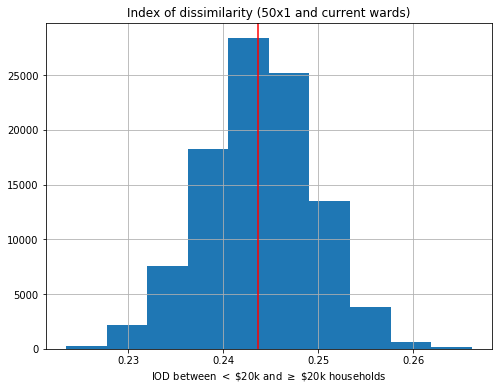

In [78]:
fig, ax = plt.subplots()
prec50_iod.hist(ax=ax, figsize=(8,6))
ax.axvline(iod_for_plan(current_plan), color="r")
ax.set_title("Index of dissimilarity (50x1 and current wards)")
ax.set_xlabel("IOD between $<$ \$20k and $\geq$ \$20k households")
plt.savefig("./IOD_20k.png")

## Pie charts

In [1]:
def how_many_over_threshold(df, threshold):
    groups = ["NH_WHITE", "NH_BLACK", "HISP", "NH_ASIAN"]
    percents = df[groups].apply(lambda col: col / df["TOTPOP"])
    return (percents > threshold).sum(axis=1)

In [4]:
df = pandas.read_csv("../ensembles/prec50/results.csv")

In [11]:
df10x5 = pandas.read_csv("../ensembles/prec10/results.csv")
df10x5ca = pandas.read_csv("../ensembles/ca10/results.csv")

In [13]:
for d, name in [(df, "50x1"), (df10x5, "10x5"), (df10x5ca, "10x5 CA")]:
    print(name)
    print("1/4th")
    print(how_many_over_threshold(d, 0.25).value_counts() / len(d))
    print()
    print("1/6th")
    print(how_many_over_threshold(d, 1/6).value_counts() / len(d))
    print()

50x1
1/4th
1    0.647488
2    0.341341
3    0.011171
dtype: float64

1/6th
2    0.459526
1    0.422039
3    0.115126
4    0.003309
dtype: float64

10x5
1/4th
1    0.543534
2    0.436135
3    0.020331
dtype: float64

1/6th
2    0.551895
1    0.274931
3    0.170820
4    0.002354
dtype: float64

10x5 CA
1/4th
1    0.549895
2    0.442186
3    0.007919
dtype: float64

1/6th
2    0.590622
1    0.255595
3    0.153726
4    0.000057
dtype: float64



## Cut edges histograms

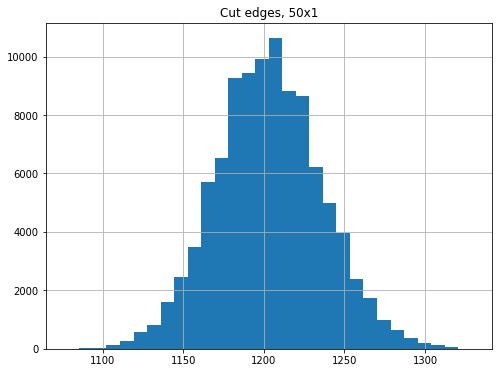

In [39]:
fig, ax = plt.subplots()
df.groupby("step").min()["cut_edges"].hist(figsize=(8,6), bins=30, ax=ax)
ax.set_title("Cut edges, 50x1")
plt.savefig("../figures/cut_edges_50x1.png")
plt.show()

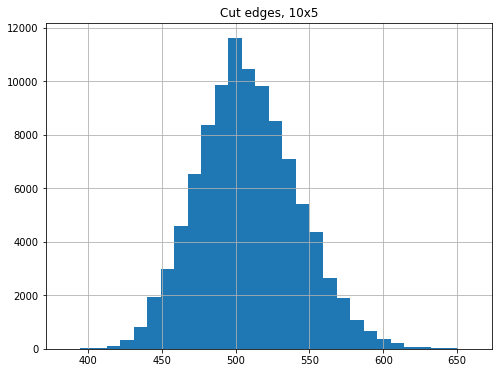

In [40]:
fig, ax = plt.subplots()
df10x5.groupby("step").min()["cut_edges"].hist(figsize=(8,6), bins=30, ax=ax)
ax.set_title("Cut edges, 10x5")
plt.savefig("../figures/cut_edges_10x5.png")
plt.show()

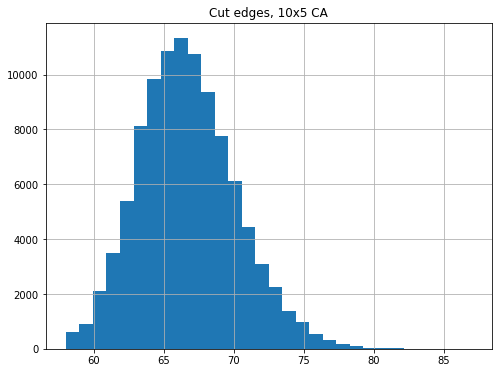

In [41]:
fig, ax = plt.subplots()
df10x5ca.groupby("step").min()["cut_edges"].hist(figsize=(8,6), bins=30, ax=ax)
ax.set_title("Cut edges, 10x5 CA")
plt.savefig("../figures/cut_edges_10x5_ca.png")
plt.show()

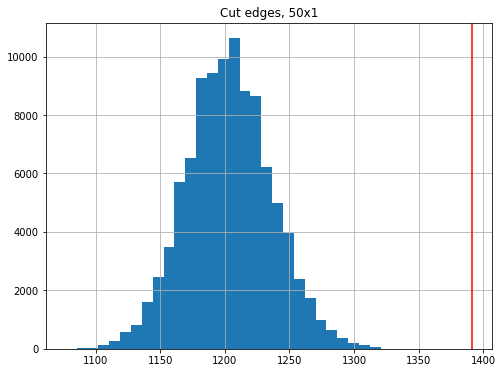

In [43]:
fig, ax = plt.subplots()
df.groupby("step").min()["cut_edges"].hist(figsize=(8,6), bins=30, ax=ax)
ax.set_title("Cut edges, 50x1")
ax.axvline(len(current_partition["cut_edges"]), color="r")
plt.savefig("../figures/cut_edges_50x1_with_current.png")
plt.show()

## Concentrated wealth and poverty

In [64]:
for d, name in [(df, "50x1"), (df10x5, "10x5"), (df10x5ca, "10x5 CA")]:
    print(name)
    print("Concentrated wealth")
    print(has_concentrated_wealth(d).groupby(d["step"]).mean().mean())
    print()
    print("Concentrated poverty")
    print(has_concentrated_poverty(d).groupby(d["step"]).mean().mean())
    print()
    print("Concentrated wealth or poverty")
    print(has_concentrated_wealth_or_poverty(d).groupby(d["step"]).mean().mean())

50x1
Concentrated wealth
0.11722900000000003

Concentrated poverty
0.36448879999999995

Concentrated wealth or poverty
0.4817178000000001
10x5
Concentrated wealth
0.089481

Concentrated poverty
0.341109

Concentrated wealth or poverty
0.4305900000000001
10x5 CA
Concentrated wealth
0.10564500000000003

Concentrated poverty
0.313089

Concentrated wealth or poverty
0.418734


In [59]:
d = current_plan

In [62]:
print("Current plan")
print("Concentrated wealth")
print(has_concentrated_wealth(d).sum().mean())
print("Concentrated poverty")
print(has_concentrated_poverty(d).sum().mean())
print("Concentrated wealth or poverty")
print(has_concentrated_wealth_or_poverty(d).sum().mean())

Current plan
Concentrated wealth
5.0

Concentrated poverty
19.0

Concentrated wealth or poverty
24.0


In [66]:
24 /50

0.48

In [77]:
has_concentrated_wealth_or_poverty(df).groupby(df["step"]).sum().idxmin()

12816

In [78]:
has_concentrated_wealth(df).groupby(df["step"]).sum()[12816]

5.0

In [79]:
has_concentrated_poverty(df).groupby(df["step"]).sum()[12816]

13.0